In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib import rc
from matplotlib.colors import LinearSegmentedColormap as colormap
from IPython.display import HTML
import functions as f
import os, sys
sys.path.append(os.path.relpath("./src"))
from kitaev_chain import kitaev_chain_model, quench_simulation_bdg, quench_simulation_tfim
from utils import to_n, s0, sx, sy, sz, power_set, tensor_product, canon_eigen, expm

In [2]:
def c(i, n, dagger=False):
    As = [sz if j < i else 0.5 * (sx + (1 if dagger else -1) * 1j * sy) if j == i else s0 for j in range(n)]
    return tensor_product(As)

## Find $U, V$

In [3]:
k = 0.01 # TODO: Another fix - change to the antisymmetric majorana basis matrix
n = 4
N = 2 ** n
zero = np.zeros((2, 1))
zero[1][0] = 1
zero = tensor_product([zero] * n)

H = kitaev_chain_model(n, 0 + k, 1 - k, 1)
H = kitaev_chain_model(n, 1, 2, 3)
H0 = H.bdg_hamiltonian()
H0_comp = H.tfim_hamiltonian()
evals, evecs = np.linalg.eigh(H0)
evals_sorted, evecs_sorted = canon_eigen(evals, evecs)

P = evecs_sorted.T
np.allclose(evecs_sorted @ np.diag(evals_sorted) @ evecs_sorted.T, H0) #sanity

True

In [4]:
U = P[:n, :n]
Us = P[n:, n:]
V = P[:n, n:]
Vs = P[n:, :n]
def psi(i, n, dagger=False):
    r = sum([c(j, n, dagger) * U[i, j] + c(j, n, not dagger) * V[i, j] for j in range(n)], np.zeros((N, N)))
    return r.conj() if dagger else r
np.allclose(U.T @ V + V.T @ U, U * 0) and np.allclose(U.T @ U + V.T @ V, np.eye(n)) and np.allclose(U, Us.conj()) and np.allclose(V, Vs.conj()) 

True

In [5]:
idx = np.where(evals_sorted > k)[0][0] # first positive eigenvalue
U_prime = U[idx:, idx:]
V_prime = V[idx:, idx:]
G = -np.linalg.inv(U_prime) @ V_prime
A = 0.5 * sum([sum([G[i - idx][j - idx] * c(i, n, True) @ c(j, n, True) for i in range(idx, n)], np.zeros((N, N))) for j in range(idx, n)], np.zeros((N, N)))
vac = expm(A, 4) @ zero
vac *= 1.0 / np.linalg.norm(vac)

array([[-2.11769344e-01+0.j],
       [-1.45233552e-15+0.j],
       [-5.39719283e-16+0.j],
       [-3.60998322e-01+0.j],
       [-5.88784672e-17+0.j],
       [-2.00530003e-01+0.j],
       [-1.67205811e-01+0.j],
       [-5.78971594e-16+0.j],
       [ 3.92523115e-17+0.j],
       [-3.33749910e-01+0.j],
       [-2.00530003e-01+0.j],
       [-7.85046229e-17+0.j],
       [-3.60998322e-01+0.j],
       [-1.13831703e-15+0.j],
       [-3.18925031e-16+0.j],
       [-6.89015833e-01+0.j]])

## Checking whether $\^{\psi}^{\dagger}_{i}\^{\psi}_{i} \^{\psi}^{\dagger}_{j}\ket{vac} = \delta^{j}_{i}\ket{vac}$

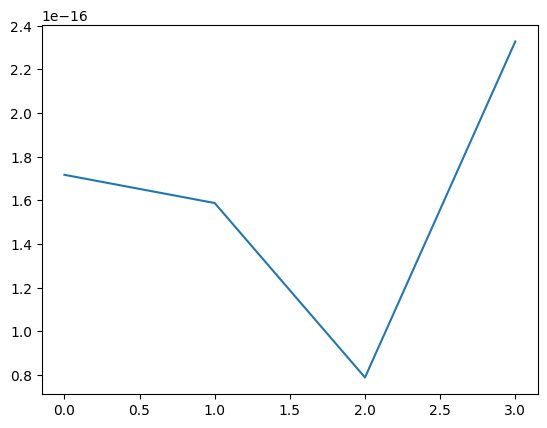

In [77]:
plt.plot([np.abs(np.linalg.norm(psi(i, n) @ vac)) for i in range(n)])

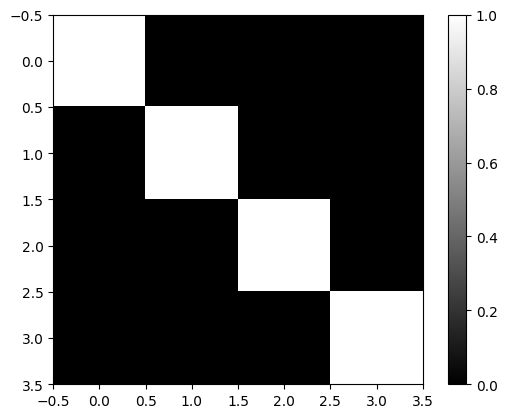

In [78]:
id = np.zeros((n, n)).astype(np.float64)
for i in range(n):
    for j in range(n):
        a = psi(j, n, dagger=True) @ vac
        b = psi(i, n, dagger=True) @ psi(i, n) @ a
        id[i, j] = np.linalg.norm(np.abs(np.dot(a.flatten(), b)))
plt.imshow(np.abs(id), cmap='gray')
plt.colorbar()

In [79]:
np.linalg.norm(np.array([psi(i, n) @ vac for i in range(n)]))

np.float64(3.3917282171583275e-16)

## Checking whether $\^H_{tfim}\^{\psi}^{\dagger}_{j}\ket{vac} = 2E_{j}\^{\psi}^{\dagger}_{j}\ket{vac}$

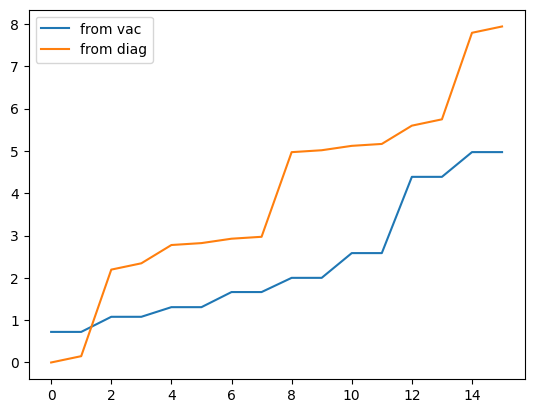

In [80]:
subsets = [[i for i in range(n) if l[i]] for l in power_set(n)]
states = []
for subset in subsets:
    psi_ = vac
    for i in subset:
        psi_ = psi(i, n, dagger=True) @ psi_
    states.append(psi_)
evals_comp_from_vac = [np.linalg.norm(psi_.T @ H0_comp @ psi_) for psi_ in states]
evals_comp, evecs_comp = np.linalg.eigh(H0_comp)
plt.plot(sorted(evals_comp_from_vac), label='from vac')
plt.plot((sorted(evals_comp) - min(evals_comp)) / 2, label='from diag')
plt.legend()

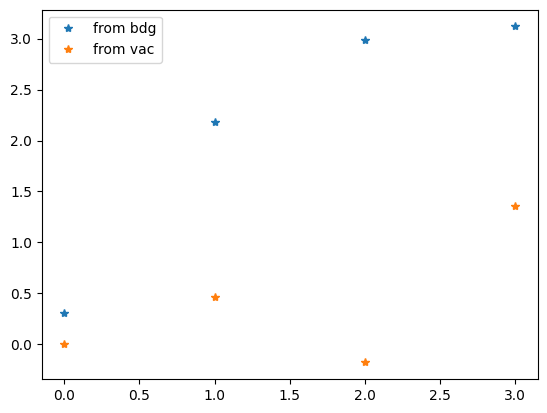

In [81]:
psi_vac = [psi(i, n, dagger=True) @ vac for i in range(n)]
evals_vac = np.array([np.abs(psi_.T @ H0_comp @ psi_)[0, 0] for psi_ in psi_vac])
plt.plot(evals_sorted[:n], '*', label='from bdg')
plt.plot((evals_vac - evals_vac[0]) / 2, '*', label='from vac')
plt.legend()

# Trying to find $\ket{vac}$ as an intersection of kernels of $\ket{\psi_{i}}$ 

In [15]:
ftol = 1e-3
def intersections(As):
    def intersections_(U, V):
        M = np.hstack((U, -V))
        nullspace = sp.linalg.null_space(M, rcond=ftol)
        nullspace_U = nullspace[:np.shape(U)[1]]
        inter = U @ nullspace_U
        for i in range(np.shape(inter)[1]):
            inter[:,i] *= 1./np.linalg.norm(inter[:,i])
        return inter
    inter = As[0]
    for A in As[1:]:
        inter = intersections_(inter, A)
    return inter

In [19]:
vacs = intersections([sp.linalg.null_space(psi(i, n), rcond=ftol) for i in range(n)])
vacs/np.linalg.norm(vacs)

array([[-6.89015833e-01+0.j],
       [ 2.57593294e-16+0.j],
       [-1.76635402e-16+0.j],
       [ 3.60998322e-01+0.j],
       [ 1.57009246e-16+0.j],
       [-2.00530003e-01+0.j],
       [ 3.33749910e-01+0.j],
       [-2.15887713e-16+0.j],
       [ 1.20210204e-16+0.j],
       [ 1.67205811e-01+0.j],
       [-2.00530003e-01+0.j],
       [ 5.15186588e-16+0.j],
       [ 3.60998322e-01+0.j],
       [-4.02336193e-16+0.j],
       [-7.45793918e-16+0.j],
       [-2.11769344e-01+0.j]])

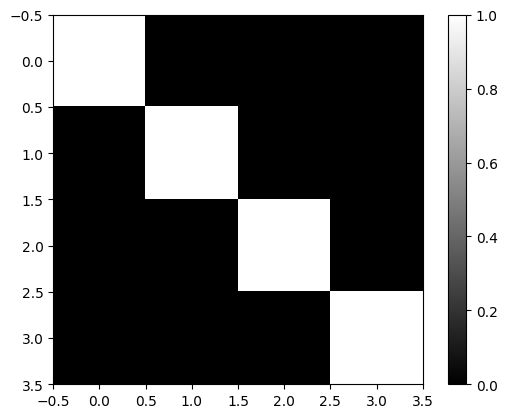

In [84]:
id = np.zeros((n, n)).astype(np.float64)
for i in range(n):
    for j in range(n):
        a = psi(j, n, dagger=True) @ vacs
        b = psi(i, n, dagger=True) @ psi(i, n) @ a
        id[i, j] = np.linalg.norm(np.abs(np.dot(a.flatten(), b)))
plt.imshow(np.abs(id), cmap='gray')
plt.colorbar()

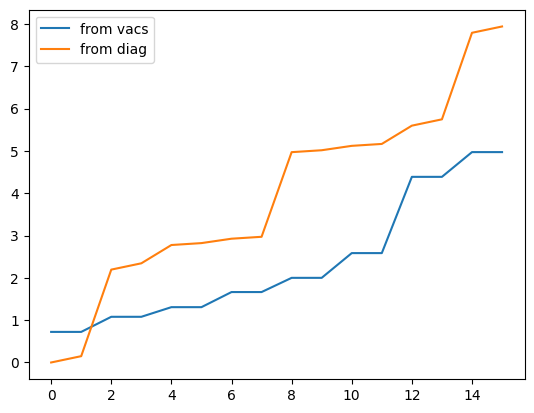

In [85]:
subsets = [[i for i in range(n) if l[i]] for l in power_set(n)]
states = []
for subset in subsets:
    psi_ = vacs
    for i in subset:
        psi_ = psi(i, n, dagger=True) @ psi_
    states.append(psi_)
evals_comp_from_vac = [np.linalg.norm(psi_.T @ H0_comp @ psi_) for psi_ in states]
evals_comp, evecs_comp = np.linalg.eigh(H0_comp)
plt.plot(sorted(evals_comp_from_vac), label='from vacs')
plt.plot((sorted(evals_comp) - min(evals_comp)) / 2, label='from diag')
plt.legend()

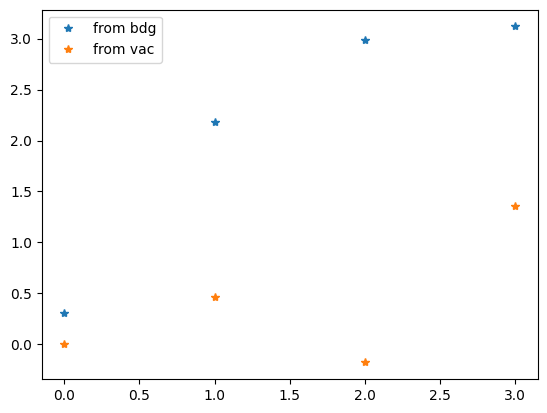

In [86]:
psi_vac = [psi(i, n, dagger=True) @ vacs for i in range(n)]
evals_vac = np.array([np.abs(psi_.T @ H0_comp @ psi_)[0, 0] for psi_ in psi_vac])
plt.plot(evals_sorted[:n], '*', label='from bdg')
plt.plot((evals_vac - evals_vac[0]) / 2, '*', label='from vac')
plt.legend()